Before we start with out notebook, I would like to thank the following resources for providing guidance and good insights in terms of Covid-19 study using Data Science:

- [Covid-19 Visualizations and predictions](https://www.kaggle.com/neelkudu28/covid-19-visualizations-predictions-forecasting/comments)
- [Time Series Forecasting with LSTMs for Daily Coronavirus Cases](https://www.curiousily.com/posts/time-series-forecasting-with-lstm-for-daily-coronavirus-cases/)

Covid-19 dataset can be found in the Colombian Health Department website:

- [Instituto Nacional de Salud](https://www.ins.gov.co/Paginas/Boletines-casos-COVID-19-Colombia.aspx)

### Import the needed libaries needed for this analysis

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import dates
from math import sqrt
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn import svm
import itertools
import warnings
from operator import itemgetter
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import layers

### Load the Covid-19 data reported in Colombia

In [2]:
path = '2020-07-15.xlsx'
df = pd.read_excel(path)
df.head()

,Caso,Fecha_not,Departamento,nombre_depa,Ciudad_municipio,nombre_mun,Edad,Sexo,Fuente_tipo_contagio,Ubicacion,...,Pais_viajo_1_cod,Pais_viajo_1_nom,Fecha_inicio_sintomas,Fecha_muerte,Fecha_diagnostico,Fecha_recuperado,Fecha cargue web,Tipo_recuperacion,per_etn_2,nom_grupo_
0,1,2020-03-02,11,Bogotá D.C.,11001,Bogotá D.C.,19,F,Importado,Recuperado,...,380,ITALIA,2020-02-27 00:00:00,NaT,2020-03-06,2020-03-13,2020-03-06,PCR,Otro,NaN
1,2,2020-03-06,76,Valle del Cauca,76111,Guadalajara de Buga,34,M,Importado,Recuperado,...,724,ESPAÑA,2020-03-04 00:00:00,NaT,2020-03-09,2020-03-19,2020-03-09,PCR,Otro,NaN
2,3,2020-03-07,5,Antioquia,5001,Medellín,50,F,Importado,Recuperado,...,724,ESPAÑA,2020-02-29 00:00:00,NaT,2020-03-09,2020-03-15,2020-03-09,PCR,Otro,NaN
3,4,2020-03-09,5,Antioquia,5001,Medellín,55,M,Relacionado,Recuperado,...,NaN,NaN,2020-03-06 00:00:00,NaT,2020-03-11,2020-03-26,2020-03-11,PCR,Otro,NaN
4,5,2020-03-09,5,Antioquia,5001,Medellín,25,M,Relacionado,Recuperado,...,NaN,NaN,2020-03-08 00:00:00,NaT,2020-03-11,2020-03-23,2020-03-11,PCR,Otro,NaN


### Let's check the size of our data and the type of each column

In [3]:
print('Size of the dataset:', df.shape)
print('data type of each column', df.dtypes)

Size of the dataset: (165169, 21)
data type of each column Caso                              int64
Fecha_not                datetime64[ns]
Departamento                      int64
nombre_depa                      object
Ciudad_municipio                  int64
nombre_mun                       object
Edad                              int64
Sexo                             object
Fuente_tipo_contagio             object
Ubicacion                        object
Estado                           object
Pais_viajo_1_cod                 object
Pais_viajo_1_nom                 object
Fecha_inicio_sintomas            object
Fecha_muerte             datetime64[ns]
Fecha_diagnostico        datetime64[ns]
Fecha_recuperado         datetime64[ns]
Fecha cargue web         datetime64[ns]
Tipo_recuperacion                object
per_etn_2                        object
nom_grupo_                       object
dtype: object


### Let's remove some columns that will not be needed

In [4]:
#dropping unnecessary columns
df.drop(['Departamento', 'Ciudad_municipio', 'nombre_mun', 'Fuente_tipo_contagio' ,'Pais_viajo_1_cod', 'Pais_viajo_1_nom',
        'Tipo_recuperacion', 'Estado', 'Fecha cargue web','per_etn_2', 'nom_grupo_'], axis=1, inplace=True)

### We will rename some of the columns so we have the names in english

In [5]:
df.rename(columns={'Caso':'Case', 'Fecha_not':'Date', 'nombre_depa':'Department', 'Edad':'Age', 'Sexo':'Sex', 
                  'Ubicacion':'Status'}, inplace=True)

### Here we will see some interesting information about the Covid-19 situation in Colombia

In [6]:
#Let's check some info from this dataset
print('Total number of confirmed cases:', df['Case'].count())
print('Total number of recovery cases:', df['Case'][df['Status']=='Recuperado'].count())
print('Total number of death cases:', df['Case'][df['Status']=='Fallecido'].count())
print('Total current cases reported at home:', df['Case'][df['Status']=='Casa'].count())
print('Total current cases in the Hospital:', 
     df['Case'][(df['Status']=='Hospital') | (df['Status']=='Hospital UCI')].count())
print('Total number of confirmed cases in the last 24 hours:', df['Case'][(df['Date']=='2020-07-07')].count())
print('Total number of death cases in the last 24 hours:',
      df['Case'][((df['Date']=='2020-07-12') | (df['Date']=='2020-07-11')) & (df['Status']=='Fallecido')].count())
print('Total reported cases in Bogotá D.C.:',
     df.groupby(['Department'])['Case'].count().sort_values(ascending=False).loc['Bogotá D.C.'])


Total number of confirmed cases: 165169
Total number of recovery cases: 71736
Total number of death cases: 5814
Total current cases reported at home: 77473
Total current cases in the Hospital: 9796
Total number of confirmed cases in the last 24 hours: 3338
Total number of death cases in the last 24 hours: 22
Total reported cases in Bogotá D.C.: 55056


### We will see the top 10 departments with more reported cases

In [7]:
#top 10 departments with reported cases
df.groupby(['Department'])['Case'].count().sort_values(ascending=False).head(10)

Department
Bogotá D.C.            55056
Barranquilla D.E.      20165
Atlántico              16260
Valle del Cauca        13929
Cartagena D.T. y C.    11403
Antioquia              11351
Nariño                  4748
Cundinamarca            4644
Sucre                   2772
Amazonas                2433
Name: Case, dtype: int64

As we can observe from the above results, Bogotá, Barranquilla, Atlántico, Valle del Cauca and Cartagena are the top 5 departments and cities that have more confirmed cases. Next, we will see the evolution of the confirmed cases for these 5 departments.

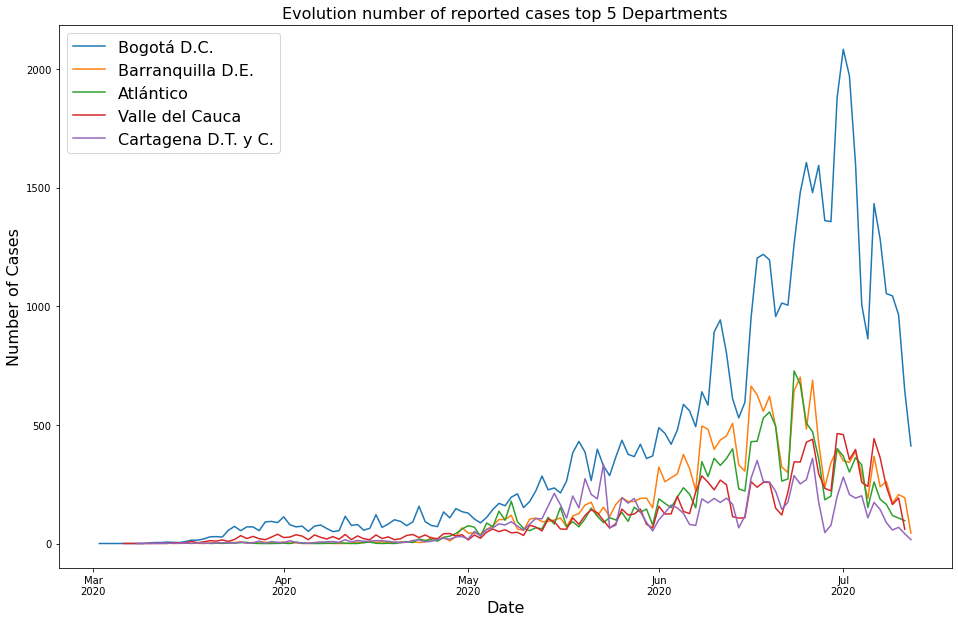

In [15]:
#Evolution number of reported cases top 5 departments
plt.figure(figsize=(16,10))
departments = ['Bogotá D.C.', 'Barranquilla D.E.', 'Atlántico', 'Valle del Cauca', 'Cartagena D.T. y C.']
for department in departments:
    df_cases_day = df.groupby(['Department', 'Date'])['Case'].count().loc[department]
    df_cases_day = df_cases_day.head(-3)
    plt.plot(df_cases_day, label=department)

plt.title('Evolution number of reported cases top 5 Departments', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Cases', fontsize=16)
plt.legend(prop={'size': 16})
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()

In Colombia, the quarantine began on March 24th. From the above plot, we can see that since that date and for approximately 30 days we did not have many cases, however, economy and health are linked and after the government decided to allow the opening of restaurants, malls, and so forth on June 1st, we see that cases began to increase.

### We will visualize the reported cases by department

Using a bar char plot, we will check the reported cases behavior of the top 10 and bottom 10 departments in the country.

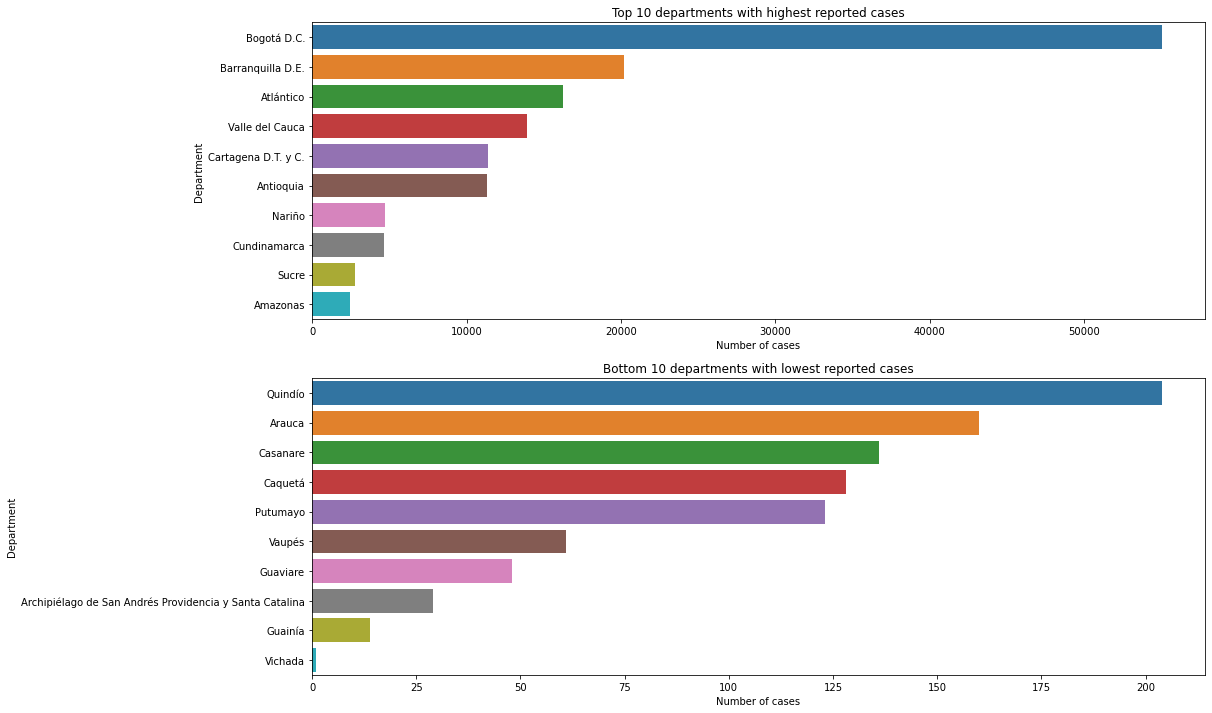

In [16]:
#top 10 and bottom 10 departments reported cases visualization
#two rows and 1 column subplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12)) 
#top 10 departments, cases count
top_10 = df.groupby(['Department'])['Case'].count().sort_values(ascending=False).head(10)
#bottom 10 departments, cases count
bottom_10 = df.groupby(['Department'])['Case'].count().sort_values(ascending=False).tail(10)
sns.barplot(y=top_10.index, x=top_10, ax=ax1).set_title('Top 10 departments with highest reported cases')
sns.barplot(y=bottom_10.index, x=bottom_10, ax=ax2).set_title('Bottom 10 departments with lowest reported cases')
ax1.set_xlabel('Number of cases')
ax1.set_ylabel('Department')
ax2.set_xlabel('Number of cases')
ax2.set_ylabel('Department')
plt.show()

From the above bar chart, we can see that Bogotá D.C. is the city with more reported cases (which we confirmed previously) and Vichada is the department with lowest reported cases.

### We will see now the distribution of closed cases

Closed cases is equal to the sum of death cases and recovery cases. We will check this distribution.

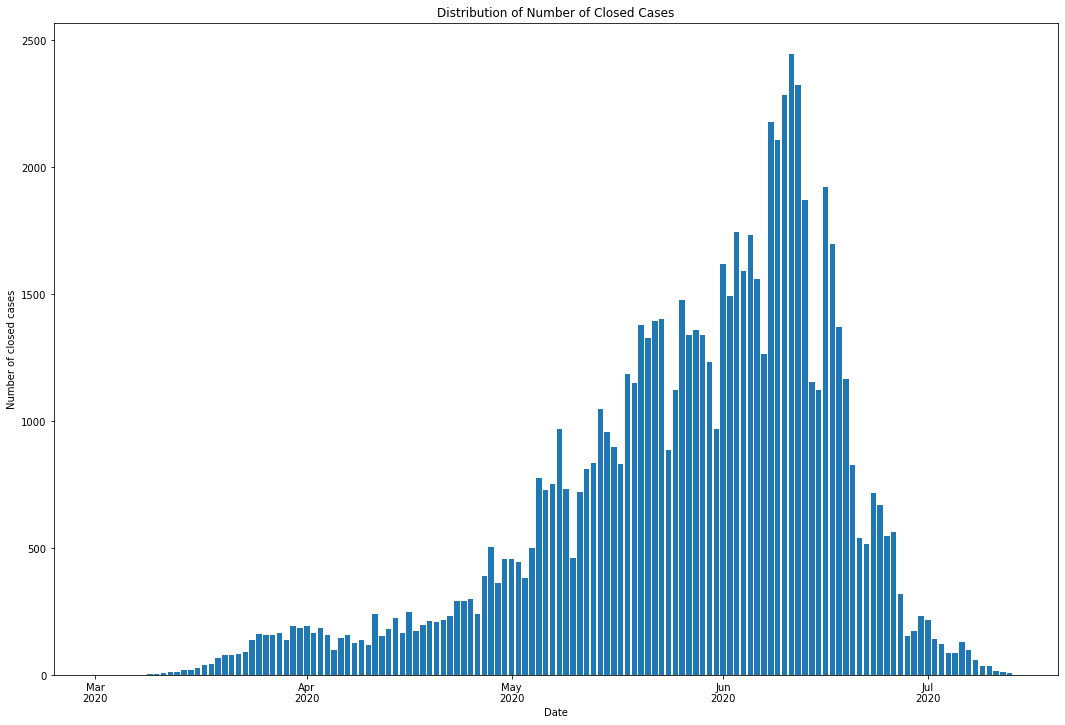

In [17]:
#Distribution of closed cases
#closed cases = recovered + deaths
closed_cases_df = df[(df['Status'] == 'Recuperado') | (df['Status'] == 'Fallecido')].groupby('Date')['Case'].count()
plt.figure(figsize=(18,12))
plt.bar(x=closed_cases_df.index, height=closed_cases_df)
plt.xlabel('Date')
plt.ylabel('Number of closed cases')
plt.title('Distribution of Number of Closed Cases')
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()


From the above chart, we can see that after the different industries were gradually opening on June 1st, the numbers of reported cases were also increasing around this date and 2 weeks later (this is approximately what it takes for someone to recover https://www.ecdc.europa.eu/en/covid-19/questions-answers) we can see an increase in the closed cases.

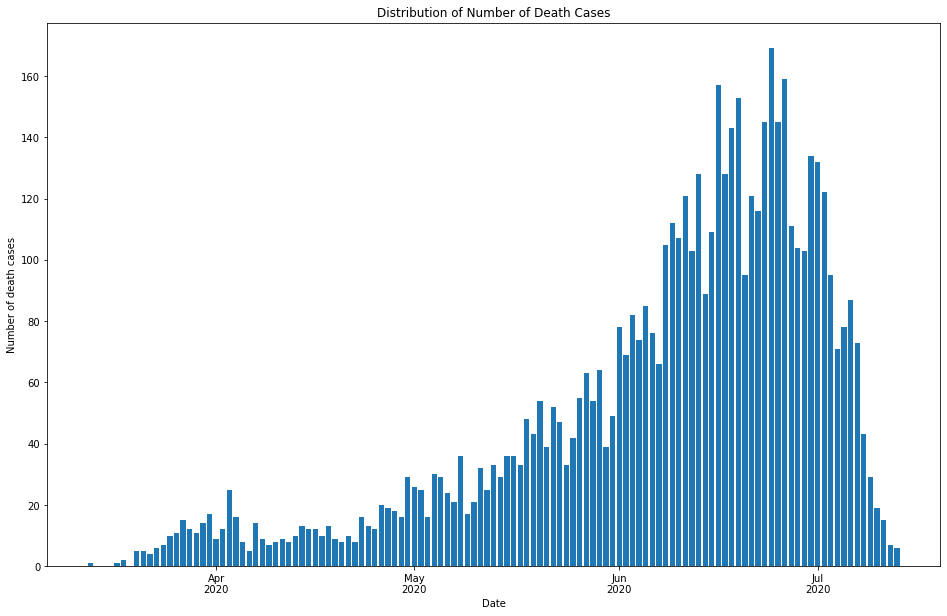

In [18]:
#Distribution of death cases
death_cases_df = df[df['Status']=='Fallecido'].groupby('Date')['Case'].count()
plt.figure(figsize=(16,10))
plt.bar(x=death_cases_df.index, height=death_cases_df)
plt.xlabel('Date')
plt.ylabel('Number of death cases')
plt.title('Distribution of Number of Death Cases')
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()

The death cases distribution chart shows an increase of cases approximately 1 month later after the quarantine was lifted for certain industries. This is correlated with the reported cases, which means that as they increase the death cases will increase.

### Let's check the mortality and recovery rate trend

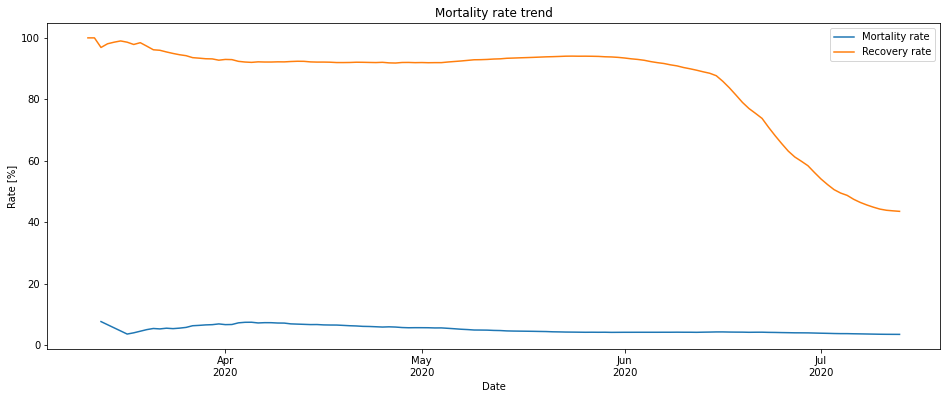

In [19]:
#Mortality and recovery rate analysis
Mortality = df[df['Status']=='Fallecido'].groupby('Date')['Case'].count()
Total_number_cases = df.groupby('Date')['Case'].count()
Total_number_cases = Total_number_cases.head(-2) #drop last two rows
Total_number_cases = Total_number_cases.tail(-6) #drop first six rows
Mortality_rate = pd.merge(Mortality, Total_number_cases, how='inner', left_index=True, right_index=True)
Mortality_rate.rename(columns={'Case_x':'Mortality', 'Case_y':'Total number cases'}, inplace=True)
Mortality_rate['Mortality rate'] = (Mortality_rate['Mortality'].cumsum()/Mortality_rate['Total number cases'].cumsum())*100

Recovery = df[df['Status']=='Recuperado'].groupby('Date')['Case'].count()
Recovery_rate = pd.merge(Recovery, Total_number_cases, how='inner', left_index=True, right_index=True)
Recovery_rate.rename(columns={'Case_x':'Recovery', 'Case_y':'Total number cases'}, inplace=True)
Recovery_rate['Recovery rate'] = (Recovery_rate['Recovery'].cumsum()/Recovery_rate['Total number cases'].cumsum())*100

plt.figure(figsize=(16,6))
plt.plot(Mortality_rate.index, Mortality_rate['Mortality rate'], label='Mortality rate')
plt.plot(Recovery_rate.index, Recovery_rate['Recovery rate'], label='Recovery rate')
plt.xlabel('Date')
plt.ylabel('Rate [%]')
plt.title('Mortality rate trend')
plt.legend()
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()

The moratility rate has maintained between 5% - 7%. Colombia was having a good recovery rate until June 16th; from this date onwards we see that this rate decreased from approximately 85% down to 54% (July 1st).

### Let's see how many confirmed cases and death cases were confirmed the last weekend

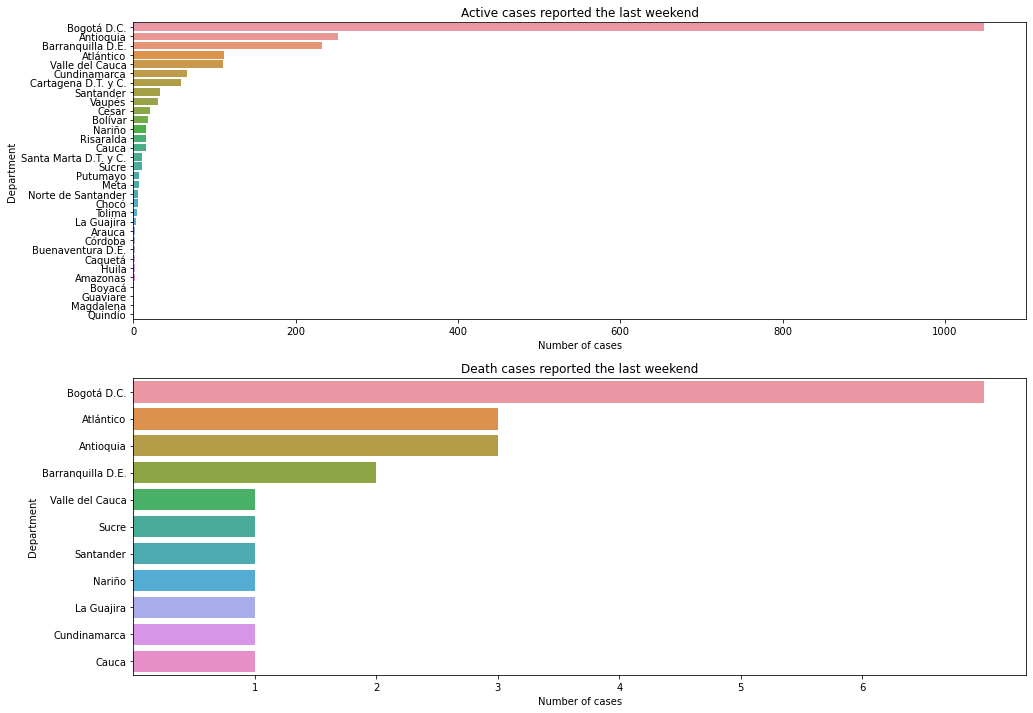

In [20]:
#Last weekend confirmed and death cases, 2020-07-11 and 2020-07-12
Last24_active = df[((df['Date']=='2020-07-11') | (df['Date']=='2020-07-12')) & ((df['Status']=='Casa') | (df['Status']=='Hospital') |
                   (df['Status']=='Hospital UCI'))].groupby('Department')['Case'].count().sort_values(ascending=False)
Last24_death = df[((df['Date']=='2020-07-11') | (df['Date']=='2020-07-12')) & (df['Status']=='Fallecido')]
Last24_death = Last24_death.groupby('Department')['Case'].count().sort_values(ascending=False)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,12))
sns.barplot(y=Last24_active.index, x=Last24_active, ax=ax1).set_title('Active cases reported the last weekend')
sns.barplot(y=Last24_death.index, x=Last24_death, ax=ax2).set_title('Death cases reported the last weekend')
plt.xticks(range(Last24_death.min(),Last24_death.max()))
ax1.set_xlabel('Number of cases')
ax1.set_ylabel('Department')
ax2.set_xlabel('Number of cases')
ax2.set_ylabel('Department')
plt.show()

We can observe that Bogotá reported more than one thousand cases during the last weekend, which is almost five times what was reported in the seconddepartment (Antioquia). We can also see that the number of death cases were low during this weekend, there were 22 death cases reported.

### Mortality rate per department

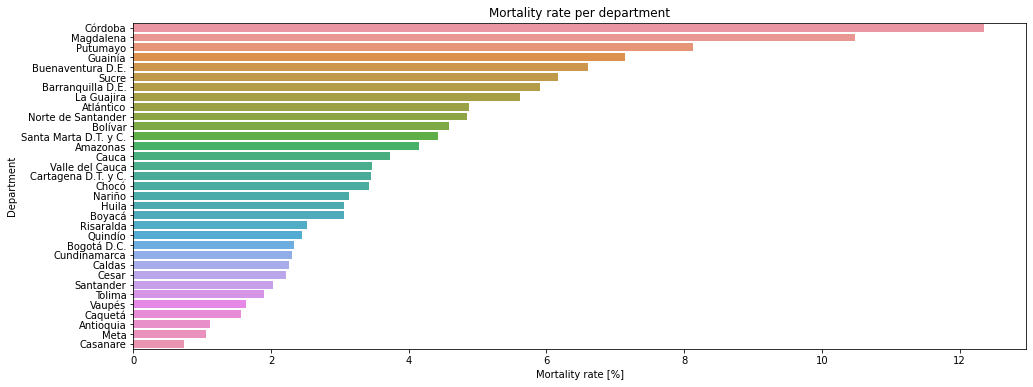

In [21]:
#Mortality rate per department
death_cases_dept = df[df['Status']=='Fallecido'].groupby(['Department'])['Case'].count()
reported_cases_dept = df.groupby(['Department'])['Case'].count()
mortality_cases_dept = pd.merge(death_cases_dept, reported_cases_dept, how='inner', left_index=True, right_index=True)
mortality_cases_dept.rename(columns={'Case_x':'Total Death Cases', 'Case_y':'Total Reported Cases'}, inplace=True)
mortality_cases_dept['Mortality rate'] = (mortality_cases_dept['Total Death Cases']/mortality_cases_dept['Total Reported Cases'])*100
mortality_cases_dept = mortality_cases_dept.sort_values(by='Mortality rate', ascending=False)
plt.figure(figsize=(16,6))
sns.barplot(y=mortality_cases_dept.index, x=mortality_cases_dept['Mortality rate']).set_title('Mortality rate per department')
plt.xlabel('Mortality rate [%]')
plt.ylabel('Department')
plt.show()

Córdoba is the department with highest mortality rate. The mortality rate for this department is approximately 12%.

### Cases by gender

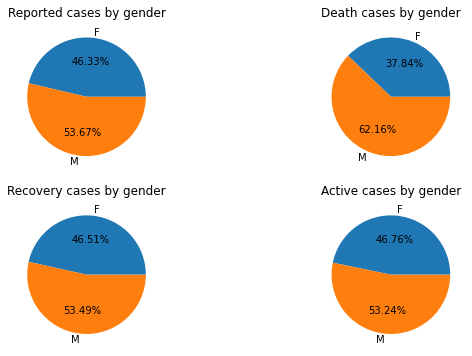

In [22]:
#cases by gender
gender_reported_cases = df.groupby(['Sex'])['Case'].count()
gender_reported_cases.iloc[0] = gender_reported_cases.iloc[0] + gender_reported_cases.iloc[2]
gender_reported_cases.iloc[1] = gender_reported_cases.iloc[1] + gender_reported_cases.iloc[3]
gender_reported_cases = gender_reported_cases.head(-2)
gender_death_cases = df[df['Status']=='Fallecido'].groupby(['Sex'])['Case'].count()
gender_recovery_cases = df[(df['Status']=='Recuperado')].groupby(['Sex'])['Case'].count()
gender_recovery_cases.iloc[0] = gender_recovery_cases.iloc[0] + gender_recovery_cases.iloc[2]
gender_recovery_cases.iloc[1] = gender_recovery_cases.iloc[1] + gender_recovery_cases.iloc[3]
gender_recovery_cases = gender_recovery_cases.head(-2)
gender_active_cases = df[(df['Status']=='Casa') | (df['Status']=='Hospital') | 
                      (df['Status']=='Hospital UCI')].groupby(['Sex'])['Case'].count()
gender_active_cases.iloc[0] = gender_active_cases.iloc[0] + gender_active_cases.iloc[2]
gender_active_cases = gender_active_cases.head(-1)

#gender_reported_cases.plot(kind='pie', autopct='%.2f')
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(10,6))
gender_reported_cases.plot(kind='pie',autopct='%.2f%%',ax=ax1)
ax1.set_title('Reported cases by gender')
ax1.set_ylabel('')
gender_death_cases.plot(kind='pie',autopct='%.2f%%',ax=ax2)
ax2.set_title('Death cases by gender')
ax2.set_ylabel('')
gender_recovery_cases.plot(kind='pie',autopct='%.2f%%',ax=ax3)
ax3.set_title('Recovery cases by gender')
ax3.set_ylabel('')
gender_active_cases.plot(kind='pie',autopct='%.2f%%',ax=ax4)
ax4.set_title('Active cases by gender')
ax4.set_ylabel('')
plt.show()

In the reported, recovery and active cases scenarios we can observe that the spread of Covid has hit males slighty more than females in Colombia.

### Let's visualize the different cases scenarios by age range

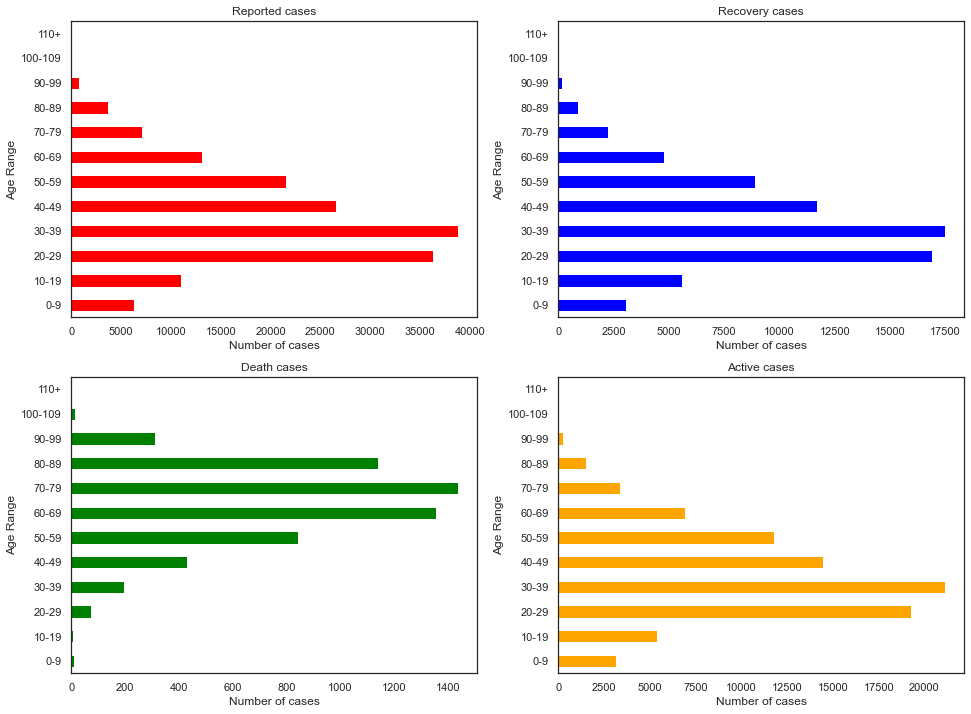

In [27]:
def agefunction(Status):
    if (Status=='Activo'):
        age_df = df[(df['Status']=='Casa') | (df['Status']=='Hospital') | 
        (df['Status']=='Hospital UCI')].groupby(['Age'])['Case'].count().reset_index()
    elif (Status == 'Reported cases'):
        age_df = df.groupby(['Age'])['Case'].count().reset_index()
    else:
        age_df = df[(df['Status']==Status)].groupby(['Age'])['Case'].count().reset_index()
    age_df.rename(columns={'Case':'Total Cases'}, inplace=True)
    age_df['Age Range'] = pd.cut(age_df['Age'], bins=bins, labels=age_labels, right=False)
    age_df = age_df.groupby(['Age Range'])['Total Cases'].sum()
    return age_df
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79',
         '80-89', '90-99', '100-109', '110+']
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 111, 112]
ages_recovery_cases = agefunction('Recuperado')
ages_death_cases = agefunction('Fallecido')
ages_active_cases = agefunction('Activo')
ages_reported_cases = agefunction('Reported cases')
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize=(16,12))
ages_reported_cases.plot(kind='barh', ax=ax1, color='red')
ages_recovery_cases.plot(kind='barh', ax=ax2, color='blue')
ages_death_cases.plot(kind='barh', ax=ax3, color='green')
ages_active_cases.plot(kind='barh', ax=ax4, color='orange')
ax1.set_title('Reported cases')
ax2.set_title('Recovery cases')
ax3.set_title('Death cases')
ax4.set_title('Active cases')
for ax in fig.get_axes():
    ax.set_xlabel('Number of cases')
plt.show()

From the above charts, we can see that the majority of reported, recovery, and active cases are within the 20-39 range. However, if we take a look at the death cases, there is a significant number within the 60-89 range, which means that the mortality rate of elderly people is high.

## Machine Learning modeling
We will use the following algorithms to analize our data:
- K-means to group the departments
- Linear regression
- Polynomial regression
- SVM (Support Vector Machine)
- LSTM for time series forecasting

## K-means

Initially, we will use the elbow method to check how many clusters we will need. First we will prepare the data before processing it.

In [32]:
#Prepare the data
reported_dpt = df.groupby(['Department'])['Case'].count()
death_dpt = df[df['Status']=='Fallecido'].groupby(['Department'])['Case'].count()
recover_dpt = df[df['Status']=='Recuperado'].groupby(['Department'])['Case'].count()
active_dpt = df[(df['Status']=='Casa') | (df['Status']=='Hospital') | 
               (df['Status']=='Hospital UCI')].groupby(['Department'])['Case'].count()
merged_1 = pd.merge(death_dpt, recover_dpt, how='inner', right_index=True, left_index=True)
merged_2 = pd.merge(active_dpt, reported_dpt, how='inner', right_index=True, left_index=True)
cluster_merged = pd.merge(merged_1, merged_2, how='inner', right_index=True, left_index=True)
cluster_merged.rename(columns={'Case_x_x':'Death cases', 'Case_y_x':'Recovered cases', 'Case_x_y':'Active cases',
                              'Case_y_y':'Reported cases'}, inplace=True)
dept = cluster_merged.index.tolist()
X = cluster_merged
X = preprocessing.MinMaxScaler().fit_transform(X) #Normalize data
X_norm = pd.DataFrame(X)
pca = PCA(n_components=2)
reduced = pd.DataFrame(pca.fit_transform(X_norm))

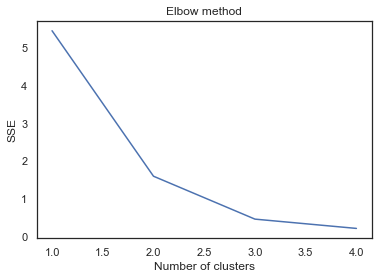

In [33]:
sse = {}
for k in range(1,5):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(reduced)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow method')
plt.show()

Since we do not have huge amount of data and the sum of squared error (SSE) is less with 3 clusters than 2, we will proceed to use the former.

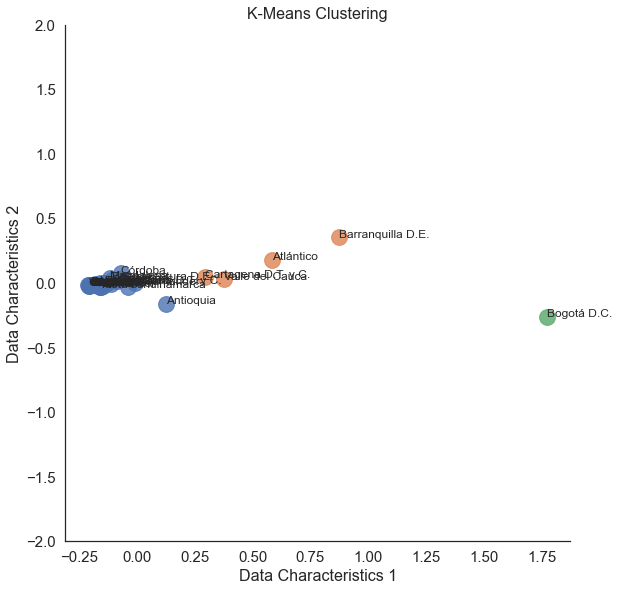

In [34]:
#%matplotlib widget

kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(reduced)
labels = kmeans.predict(reduced)
centroid = kmeans.cluster_centers_
clusters = kmeans.labels_.tolist()
reduced['clusters'] = clusters
reduced['Departments'] = dept
reduced.rename(columns={0:'x', 1:'y',}, inplace=True)

#plot the data
sns.set(style='white')
ax = sns.lmplot(x="x", y="y", hue='clusters', data = reduced, legend=False,
                   fit_reg=False, height=8, scatter_kws={"s": 250})
texts = []
for x, y, s in zip(reduced.x, reduced.y, reduced.Departments):
    texts.append(plt.text(x, y, s))
ax.set(ylim=(-2,2))
plt.tick_params(labelsize=15)
plt.xlabel("Data Characteristics 1", fontsize = 16)
plt.ylabel("Data Characteristics 2", fontsize = 16)
plt.title('K-Means Clustering', fontsize=16)
plt.show()

By clustering the departments we can see that we have three groups, the first one is the cluster that contains Bogotá which is the city with more cases in the country, in the second cluster we have Barranquilla, Cartagena, Atlántico and Valle del Cauca which are the cities and departments with more cases and in the third cluster we have the rest of the departments.

## Linear Regression

We need to split our data into our training and test set, we will use 80% of our data set for the training set and the rest for the test set. It is also important to convert the date data to ordinal for further processing (Gregorian Calendar).

In [35]:
df_ML = df.groupby('Date')['Case'].count().head(-4).reset_index()
df_ML['Date'] = df_ML['Date'].map(dt.datetime.toordinal)
X = np.array(df_ML['Date']).reshape(-1,1)
y = np.array(df_ML['Case']).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [36]:
#Fit the model
clf_LR = LinearRegression()
lr_model = clf_LR.fit(X_train, y_train)
#Predict using the test set
y_hat_LR = lr_model.predict(X_test)
#Convert to df and convert the date
X_LR = pd.DataFrame(X)
X_LR = X_LR.rename(columns={0:'Date'})
X_LR['Date'] = X_LR['Date'].map(dt.datetime.fromordinal)
X_test_LR = pd.DataFrame(X_test)
X_test_LR = X_test_LR.rename(columns={0:'Date'})
X_test_LR['Date'] = X_test_LR['Date'].map(dt.datetime.fromordinal)

Let's check the coefficients, intercepts and error.

In [63]:
print('coefficients:', clf_LR.coef_[0][0])
print('intercept:', clf_LR.intercept_[0])
print('RMSE: %.2f' % sqrt(mean_squared_error(y_hat_LR, y_test)))
print('R2 score: %.2f' % r2_score(y_hat_LR, y_test))

coefficients: 30.508205953479102
intercept: -22500181.51584999
RMSE: 919.56
R2 score: 0.41


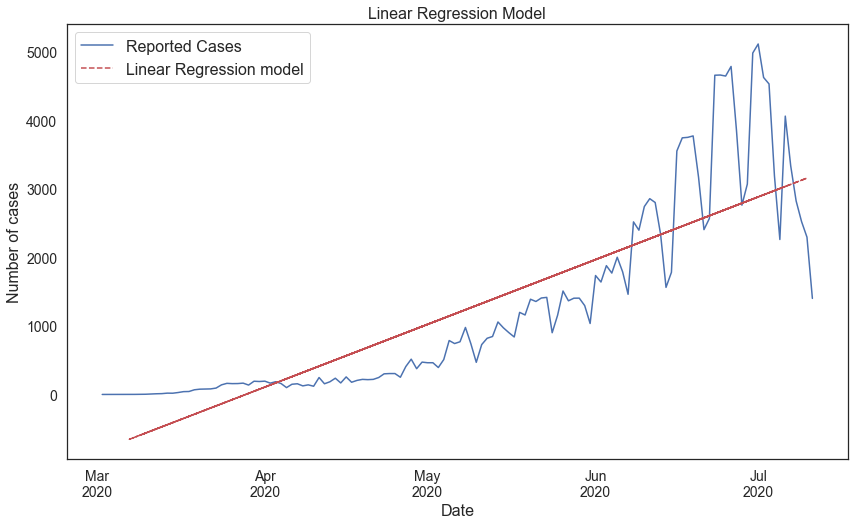

In [38]:
plt.figure(figsize=(14,8))
plt.plot(X_LR, y)
plt.plot(X_test_LR, y_hat_LR, 'r--')
plt.legend(['Reported Cases','Linear Regression model'], prop={'size': 16})
plt.title('Linear Regression Model', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()

### Polynomial Regression

We will use polynomial regression to check a better fit for our data.

Initially, we train our algorithm with the train set and then we predict the number of cases using the test set. We will use a second degree polynomial.

In [39]:
poly = PolynomialFeatures(degree=2)
train_x_poly = poly.fit_transform(X_train)
test_x_poly = poly.fit_transform(X_test)
clf_poly = LinearRegression()
clf_poly.fit(train_x_poly, y_train)
y_hat_poly = clf_poly.predict(test_x_poly)

Here we will organize our data in order to plot it afterwards.

In [40]:
y_hat_poly = pd.DataFrame(y_hat_poly).rename(columns={0:'Reported cases'})
y_test_poly = pd.DataFrame(y_test).rename(columns={0:'Reported cases'})
X_test_poly = pd.DataFrame(X_test)
X_test_poly = X_test_poly.rename(columns={0:'Date'})
X_test_poly['Date'] = X_test_poly['Date'].map(dt.datetime.fromordinal)
X_poly = pd.DataFrame(X)
X_poly = X_poly.rename(columns={0:'Date'})
X_poly['Date'] = X_poly['Date'].map(dt.datetime.fromordinal)
prediction_poly = pd.merge(X_test_poly, y_hat_poly, how='inner', left_index=True, right_index=True)
prediction_poly = prediction_poly.sort_values(by='Date')

Let's check coefficients, intercepts and error.

In [62]:
print('coefficients:', clf_poly.coef_[0])
print('intercepts:', clf_poly.intercept_)
print('RMSE: %.2f' % sqrt(mean_squared_error(y_hat_poly, y_test)))
print('R2 score: %.2f' % r2_score(y_hat_poly, y_test))

coefficients: [ 0.00000000e+00 -4.90135644e+05  3.32293475e-01]
intercepts: [1.8073854e+11]
RMSE: 830.54
R2 score: 0.70


We can see here that our R2 score increased significantly, which is good, and also the MSE decreased compared with our Linear Regression Model.

Let's plot our data and compare the reported cases trend with our model.

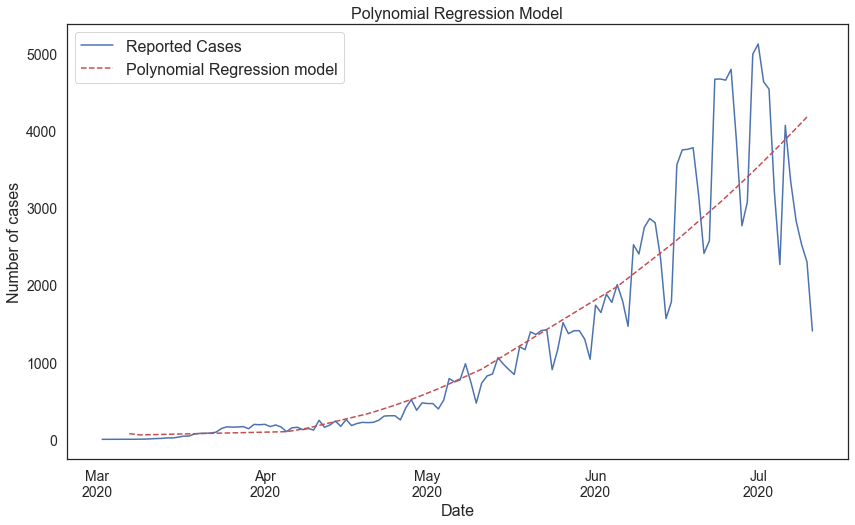

In [42]:
plt.figure(figsize=(14,8))
plt.plot(X_poly['Date'], y)
plt.plot(prediction_poly['Date'], prediction_poly['Reported cases'], 'r--')
plt.legend(['Reported Cases','Polynomial Regression model'], prop={'size': 16})
plt.title('Polynomial Regression Model', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()

### Support Vector Machine (SVM)

Similarly to the previous algorithms, we will train our model and then predict the number of cases using the test set.

In [44]:
SVM_model = svm.SVC()
SVM_model.fit(X_train, y_train.ravel())
y_hat_SVM = SVM_model.predict(X_test)

We need to organize our data so we can plot it and visualize the results.

In [49]:
X_test_SVM = pd.DataFrame(X_test)
X_test_SVM = X_test_SVM.rename(columns={0:'Date'})
X_test_SVM['Date'] = X_test_SVM['Date'].map(dt.datetime.fromordinal)
X_SVM = pd.DataFrame(X)
X_SVM = X_SVM.rename(columns={0:'Date'})
X_SVM['Date'] = X_SVM['Date'].map(dt.datetime.fromordinal)
y_hat_SVM = pd.DataFrame(y_hat_SVM).rename(columns={0:'Reported cases'})
prediction_SVM = pd.merge(X_test_SVM, y_hat_SVM, how='inner', left_index=True, right_index=True)
prediction_SVM = prediction_SVM.sort_values(by='Date')

Let's take a look at the error.

In [65]:
print('RMSE: %.2f' % sqrt(mean_squared_error(y_hat_SVM, y_test)))
print('R2 score: %.2f' % r2_score(y_hat_SVM, y_test))

RMSE: 379.32
R2 score: 0.96


R2 score increased compared to our polynomial model and the MSE decreased even more.

Let's visualize our model and compare it with our reported cases data.

In [55]:
#use the full set and predict it using the SVM model
predicted = SVM_model.predict(X)
predicted = pd.DataFrame(predicted).rename(columns={0:'Reported cases'})
predicted = pd.merge(X_SVM, predicted, how='inner', left_index=True, right_index=True)
predicted = predicted.sort_values(by='Date')

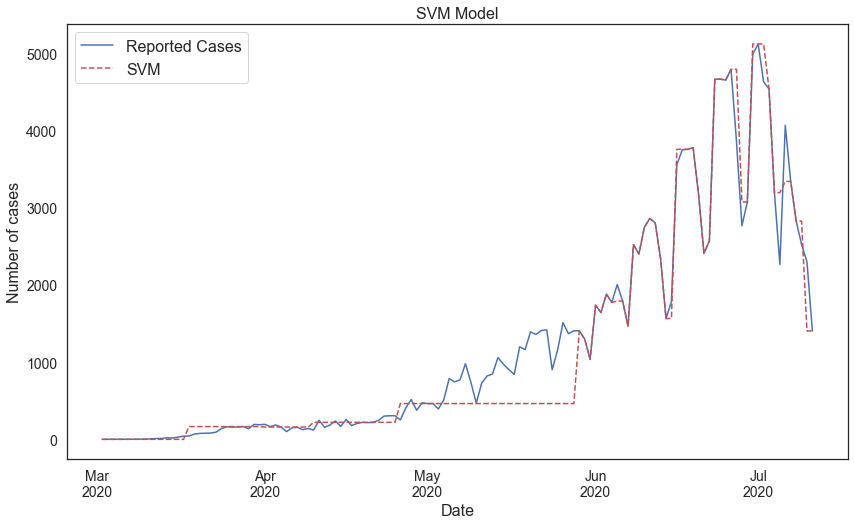

In [56]:
plt.figure(figsize=(14,8))
plt.plot(X_SVM['Date'], y)
plt.plot(predicted['Date'], predicted['Reported cases'], 'r--')
plt.legend(['Reported Cases','SVM'], prop={'size': 16})
plt.title('SVM Model', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()

Let's take a look at the RMSE and R2 Score results for each of our models:

|| Linear Regression | Polynomial Regression | SVM |
|------|------|------|------|
| RMSE | 919.56 | 830.54 | 379.32 |
| R2 Score | 0.40 | 0.70 | 0.96 |

We can observe that the model that best suited our data was the SVM as it is giving less error and the R2 score is 0.96.

### Recurrent Neural Network - LSTM

First, we are going to create a new dataset that only contains the date as our index and the number of cases reported.

In [91]:
covid_cases = df.groupby('Date')['Case'].count().head(-4).reset_index()
covid_cases.set_index('Date', inplace=True)
#covid_cases.head()

In [92]:
covid_cases.shape

(129, 1)

Now, we need to split our data into train and test sets. We will use 29 as our test size.

In [93]:
test_size = 29

We split our data into train and tests sets. We will use 25 as our test size and scale the number of cases using MinMaxScaler from scikit-learn.

In [94]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(covid_cases)
train_data = scaled[:-test_size]
test_data = scaled[-test_size:]

The next step is to create a sequence. With this, we are going to add another dimension, which is the time step to our train and test sets.

In [95]:
def sequence(data, sequence_length):
    xs = []
    ys = []
    
    for i in range (len(data)-sequence_length):
        x = data[i:(i+sequence_length)]
        y = data[i+sequence_length]
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

sequence_length = 2

X_train_nn, y_train_nn = sequence(train_data, sequence_length)
X_test_nn, y_test_nn = sequence(test_data, sequence_length)

Now we can initiate the LSTM model.

In [96]:
model = Sequential()
model.add(LSTM((5), batch_input_shape=(None,2,1), return_sequences=True))
model.add(LSTM((1), return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [97]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2, 5)              140       
_________________________________________________________________
lstm_3 (LSTM)                (None, 1)                 28        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________


Using the train set, we can fit our model.

In [98]:
history = model.fit(X_train_nn, y_train_nn, epochs=200, validation_data=(X_test_nn,y_test_nn))

Epoch 1/200
4/4 [==============================] - 1s 232ms/step - loss: 0.0365 - accuracy: 0.0102 - val_loss: 0.5064 - val_accuracy: 0.0000e+00
Epoch 2/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0348 - accuracy: 0.0102 - val_loss: 0.4965 - val_accuracy: 0.0000e+00
Epoch 3/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0331 - accuracy: 0.0102 - val_loss: 0.4873 - val_accuracy: 0.0000e+00
Epoch 4/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0318 - accuracy: 0.0102 - val_loss: 0.4781 - val_accuracy: 0.0000e+00
Epoch 5/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0304 - accuracy: 0.0102 - val_loss: 0.4690 - val_accuracy: 0.0000e+00
Epoch 6/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0291 - accuracy: 0.0102 - val_loss: 0.4595 - val_accuracy: 0.0000e+00
Epoch 7/200
4/4 [==============================] - 0s 17ms/step - loss: 0.0278 - accuracy: 0.0102 - val_loss: 0.4505 - val_accuracy: 0.

4/4 [==============================] - 0s 13ms/step - loss: 0.0158 - accuracy: 0.0102 - val_loss: 0.2540 - val_accuracy: 0.0000e+00
Epoch 58/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0156 - accuracy: 0.0102 - val_loss: 0.2540 - val_accuracy: 0.0000e+00
Epoch 59/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0154 - accuracy: 0.0102 - val_loss: 0.2548 - val_accuracy: 0.0000e+00
Epoch 60/200
4/4 [==============================] - 0s 15ms/step - loss: 0.0153 - accuracy: 0.0102 - val_loss: 0.2550 - val_accuracy: 0.0000e+00
Epoch 61/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0151 - accuracy: 0.0102 - val_loss: 0.2531 - val_accuracy: 0.0000e+00
Epoch 62/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0150 - accuracy: 0.0102 - val_loss: 0.2524 - val_accuracy: 0.0000e+00
Epoch 63/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0148 - accuracy: 0.0102 - val_loss: 0.2515 - val_accuracy: 0.0000e+0

4/4 [==============================] - 0s 14ms/step - loss: 0.0037 - accuracy: 0.0102 - val_loss: 0.0730 - val_accuracy: 0.0370
Epoch 114/200
4/4 [==============================] - 0s 16ms/step - loss: 0.0034 - accuracy: 0.0102 - val_loss: 0.0689 - val_accuracy: 0.0370
Epoch 115/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0034 - accuracy: 0.0102 - val_loss: 0.0655 - val_accuracy: 0.0370
Epoch 116/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0032 - accuracy: 0.0102 - val_loss: 0.0633 - val_accuracy: 0.0370
Epoch 117/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0031 - accuracy: 0.0102 - val_loss: 0.0619 - val_accuracy: 0.0370
Epoch 118/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0030 - accuracy: 0.0102 - val_loss: 0.0612 - val_accuracy: 0.0370
Epoch 119/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0029 - accuracy: 0.0102 - val_loss: 0.0610 - val_accuracy: 0.0370
Epoch 120/200
4/4 [=

Epoch 171/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0437 - val_accuracy: 0.0370
Epoch 172/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0436 - val_accuracy: 0.0370
Epoch 173/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0433 - val_accuracy: 0.0370
Epoch 174/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0431 - val_accuracy: 0.0370
Epoch 175/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0429 - val_accuracy: 0.0370
Epoch 176/200
4/4 [==============================] - 0s 13ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0430 - val_accuracy: 0.0370
Epoch 177/200
4/4 [==============================] - 0s 14ms/step - loss: 0.0013 - accuracy: 0.0102 - val_loss: 0.0430 - val_accuracy: 0.0370
Epoch 

Let's plot the loss vs number of iterations to check whether 200 iterations were enough.

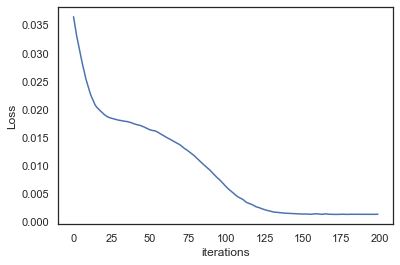

In [117]:
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.show()

From the above plot we can see that 200 iterations is enough as the loss maintains after 150 iterations, therefore we are not using too much computational resources. 

With the model that we set up, let's use our current data and visually check whether it is a good fit.

First, let's create the sequence.

In [100]:
X_rnn, y_rnn = sequence(scaled, sequence_length)

Now we use the data to predict the results.

In [101]:
results = model.predict(X_rnn)

We proceed now to "unnormalize" the data.

In [102]:
results = scaler.inverse_transform(results).flatten()

Now we organize the data in order to plot the results.

In [103]:
results = pd.DataFrame(results)
results.rename(columns={0:'Case'}, inplace=True)
results = pd.merge(results, covid_cases.reset_index()['Date'], how='inner', left_index=True, right_index=True)

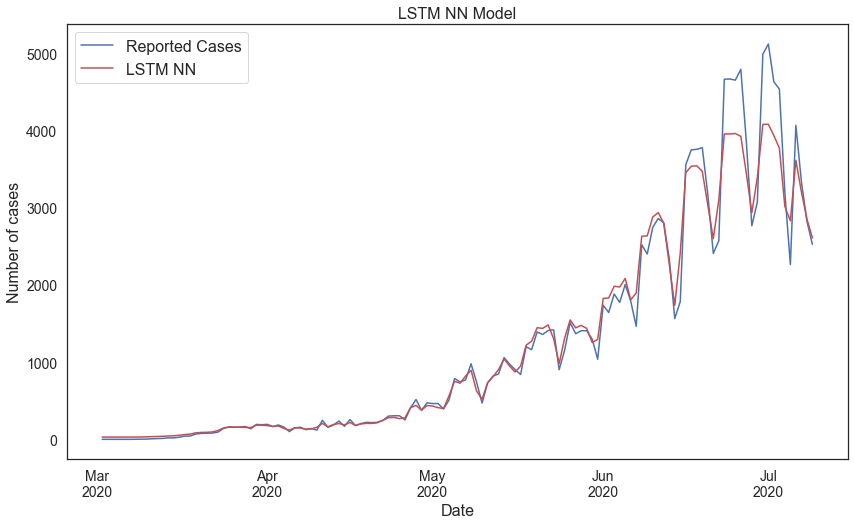

In [104]:
plt.figure(figsize=(14,8))
plt.plot(covid_cases.index[:-sequence_length], covid_cases['Case'][:-sequence_length], c='b')
plt.plot(results['Date'], results['Case'], 'r')
plt.legend(['Reported Cases','LSTM NN'], prop={'size': 16})
plt.title('LSTM NN Model', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_locator(dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%b\n%Y"))
plt.show()
plt.show()

From the above plot, we can see that the model is predicting quite good the results up until mid of June and after this period the reported cases prediction is lower than the real results.

We will use the model to predict the new cases from July 10 until July 24th. We will load the new data so we can compare how good our model predict the new cases reported.

Let's clean the data.

In [105]:
path_2 = '2020-07-28.xlsx'
df_2 = pd.read_excel(path_2)
df_2.head()

,Caso,Fecha_not,Departamento,nombre_depa,Ciudad_municipio,nombre_mun,Edad,Sexo,Fuente_tipo_contagio,Ubicacion,...,Pais_viajo_1_cod,Pais_viajo_1_nom,Fecha_inicio_sintomas,Fecha_muerte,Fecha_diagnostico,Fecha_recuperado,Fecha cargue web,Tipo_recuperacion,per_etn_2,0m_grupo_
0,56867,2020-07-13,5,Antioquia,5088,Bello,27.0,F,En estudio,Casa,...,NaN,NaN,2020-07-08 00:00:00,NaT,2020-07-17,NaT,2020-06-17,NaN,Otro,NaN
1,66606,2020-07-10,76,Valle del Cauca,76892,Yumbo,14.0,F,En estudio,Casa,...,NaN,NaN,2020-07-10 00:00:00,NaT,NaT,NaT,2020-06-21,NaN,Otro,NaN
2,82584,2020-07-15,76,Valle del Cauca,76001,Cali,59.0,M,En estudio,Hospital,...,NaN,NaN,2020-07-05 00:00:00,NaT,2020-07-19,NaT,2020-06-26,NaN,NaN,NaN
3,83030,2020-07-15,76,Valle del Cauca,76001,Cali,55.0,M,En estudio,Casa,...,NaN,NaN,2020-06-30 00:00:00,NaT,2020-07-19,NaT,2020-06-26,NaN,NaN,NaN
4,86121,2020-07-10,76,Valle del Cauca,76001,Cali,23.0,F,En estudio,Casa,...,NaN,NaN,2020-07-10 00:00:00,NaT,2020-07-19,NaT,2020-06-27,NaN,NaN,NaN


In [106]:
df_2.drop(['Departamento', 'Ciudad_municipio', 'nombre_mun', 'Fuente_tipo_contagio' ,'Pais_viajo_1_cod', 'Pais_viajo_1_nom',
        'Tipo_recuperacion', 'Estado', 'Fecha cargue web','per_etn_2', '0m_grupo_'], axis=1, inplace=True)

In [107]:
df_2.rename(columns={'Caso':'Case', 'Fecha_not':'Date', 'nombre_depa':'Department', 'Edad':'Age', 'Sexo':'Sex', 
                  'Ubicacion':'Status'}, inplace=True)

In [108]:
future_cases = df_2.groupby('Date')['Case'].count().head(-1).reset_index()
covid_cases_nn = covid_cases.reset_index().append(future_cases).groupby('Date')['Case'].sum().reset_index()
covid_cases_nn.set_index('Date', inplace=True)

We then normalize the data.

In [109]:
scaled_predictions = scaler.fit_transform(covid_cases_nn)

Let's  create the sequence.

In [110]:
X_predict, y_predict = sequence(scaled_predictions, sequence_length)

Now we proceed to predict the reported cases using our model.

In [111]:
future_predictions = model.predict(X_predict)

In [112]:
future_predictions = scaler.inverse_transform(future_predictions).flatten()

In [113]:
future_predictions = pd.DataFrame(future_predictions)
future_predictions.rename(columns={0:'Case'}, inplace=True)
future_predictions = pd.merge(future_predictions, covid_cases_nn.reset_index()['Date'], how='inner', left_index=True, right_index=True)

Let's check the predictions and compare them to our model.

In [114]:
predictions = future_predictions.tail(15)
next_days_cases = covid_cases_nn[-17:-sequence_length]

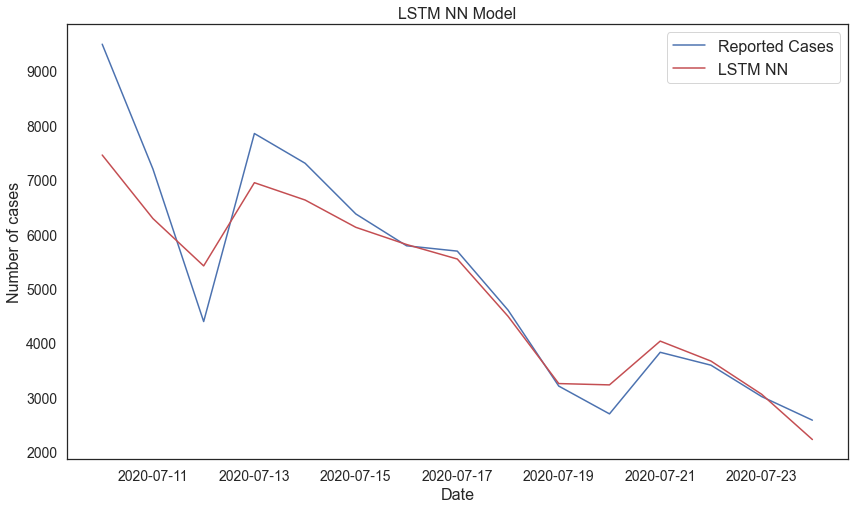

In [115]:
plt.figure(figsize=(14,8))
plt.plot(next_days_cases.index, next_days_cases['Case'], c='b')
plt.plot(predictions['Date'], predictions['Case'], 'r')
plt.legend(['Reported Cases','LSTM NN'], prop={'size': 16})
plt.title('LSTM NN Model', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of cases', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.show()

We can see that from July 11th until July 14th we have some noticeable differences between our model and the reported cases, however after July 15th the differences in the reported cases decreases in our model.

## Conclusions

In this project we used some data science techniques in order to visualize and understand the current Covid-19 situation in Colombia. We saw that Bogotá D.C. is the city with highest reported cases and Vichada is the department with lowest reported cases. We also saw that the mortality rate of this dissease is very low, namely between 5-7%. Additionally the recovery rate was high during the first three months (85% approximately) and then it decreased down to 54%. In all the scenarios (reported, death, active and recovery cases), we saw higher rates in men than women. Moreover, we saw that high death cases are concentrated in the 60-89 range. Some ML algorithms were applied, namely Linear Regression, Polynomial Regression, Support Vector Machine, K-Means and Long-Short Term Memory Neural Network in order to predict models to fit our data.